# Volkswagen Stock Price Analysis

Analysis and forecasting of the Volkswagen stock price, and how it faired through seminal moments like the first and second aquisition of Porsche, the Diesel gate scandal, and Corona virus pandemic.

## Importing the Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [2]:
raw_data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval = "1d", group_by = 'ticker',
                              auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [3]:
df = raw_data.copy()

In [4]:
# check for missing values
df.isna().sum()

PAH3.DE  Open      3165
         High      3165
         Low       3165
         Close     3165
         Volume    3165
VOW3.DE  Open       443
         High       443
         Low        443
         Close      443
         Volume     443
BMW.DE   Open         0
         High         0
         Low          0
         Close        0
         Volume       0
dtype: int64

In [5]:
df.head()

PAH3.DE                       VOW3.DE                        \
              Open High Low Close Volume    Open High Low Close Volume   
Date                                                                     
1996-11-08     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-11     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-12     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-13     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   
1996-11-14     NaN  NaN NaN   NaN    NaN     NaN  NaN NaN   NaN    NaN   

              BMW.DE                                         
                Open      High       Low     Close   Volume  
Date                                                         
1996-11-08  9.353779  9.353779  9.333747  9.333747   767000  
1996-11-11  9.343508  9.348645  9.288033  9.308578   260000  
1996-11-12  9.328610  9.414391  9.293167  9.378949  1066000  
1996-11-13  9.422607  9.422607  9.343504  9.364050   793000  
1996-11-14  9.351210  9.394358  9.313713  9.394358   351000

From the result above, we can see there are some missing values, so we will start the time series from a date where all values where recorded (2009-04-05)

## Defining Key Dates

In [6]:
# Starting Date -  self defined time series start date, where stock prices for both companies where recorded.
start_date = "2009-04-05" 

# First Official Announcement - Volkswagen Acquires 49.9% of Porsche
ann_1 = "2009-12-09" 

# Second Official Announcement - Volkswagen acquires the remaining 51.1% of Porsche, giviing them 100% ownership.
ann_2 = "2012-07-05" 

#Ending Date - Self defined time series ending date
end_date = "2014-01-01"
# end_date = "2014-01-01"

# Dieselgate - Start of the Diesel Gate scandal
d_gate = '2015-09-20'

# Corona Virus start - second Ending Date : Self defined time series ending date and the start of the corona virus pandemic
end_date2 = '2019-12-31'

# Global lockdown - By March 2020 most countries declared nationwide emergency and lockedown their borders
lockdown = '2020-03-01'

# easing of lockdown
lockdown_ease = '2021-01-01'

### CDC Museum COVID-19 Timeline

You can check the link below for the official CDC COVID-19 Timeline:
https://www.cdc.gov/museum/timeline/covid19.html#:~:text=January%2023%2C%202020,the%202019%20Novel%20Coronavirus%20outbreak.

In [7]:
# check for missing values
df[start_date:].isna().sum()

PAH3.DE  Open      0
         High      0
         Low       0
         Close     0
         Volume    0
VOW3.DE  Open      0
         High      0
         Low       0
         Close     0
         Volume    0
BMW.DE   Open      0
         High      0
         Low       0
         Close     0
         Volume    0
dtype: int64

## Pre-processing the Data

In [8]:
# Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extracting Volume
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [9]:
# Assigning the Frequency and Filling NA Values

# Setting frequency as Business-day
df = df.asfreq('b')

# Fills in missing values, with the next valid observation.
df = df.fillna(method='bfill') 

In [10]:
# Confirming again, there are no more missing variables.
df.isnull().sum().sum()

0

In [11]:
df.head()

PAH3.DE                                               VOW3.DE  \
                 Open       High        Low      Close    Volume       Open   
Date                                                                          
1996-11-08  24.544909  25.909124  24.243576  25.596832  901566.0  31.304902   
1996-11-11  24.544909  25.909124  24.243576  25.596832  901566.0  31.304902   
1996-11-12  24.544909  25.909124  24.243576  25.596832  901566.0  31.304902   
1996-11-13  24.544909  25.909124  24.243576  25.596832  901566.0  31.304902   
1996-11-14  24.544909  25.909124  24.243576  25.596832  901566.0  31.304902   

                                                     ...       bmw   ret_vol  \
                High        Low      Close   Volume  ...                       
Date                                                 ...                       
1996-11-08  32.24955  31.304902  32.022873  56336.0  ...  9.333747 -4.405628   
1996-11-11  32.24955  31.304902  32.022873  56336.0  ...  9.308578 -4.405628   
1996-11-12  32.24955  31.304902  32.022873  56336.0  ...  9.378949 -4.405628   
1996-11-13  32.24955  31.304902  32.022873  56336.0  ...  9.364050 -4.405628   
1996-11-14  32.24955  31.304902  32.022873  56336.0  ...  9.394358 -4.405628   

             ret_por   ret_bmw     sq_vol     sq_por    sq_bmw    q_vol  \
                                                                          
Date                                                                      
1996-11-08 -3.831324 -0.269650  19.409556  14.679045  0.072711  56336.0   
1996-11-11 -3.831324 -0.269650  19.409556  14.679045  0.072711  56336.0   
1996-11-12 -3.831324  0.755977  19.409556  14.679045  0.571501  56336.0   
1996-11-13 -3.831324 -0.158858  19.409556  14.679045  0.025236  56336.0   
1996-11-14 -3.831324  0.323661  19.409556  14.679045  0.104756  56336.0   

               q_por      q_bmw  
                                 
Date                             
1996-11-08  901566.0   767000.0  
1996-11-11  901566.0   260000.0  
1996-11-12  901566.0  1066000.0  
1996-11-13  901566.0   793000.0  
1996-11-14  901566.0   351000.0  

[5 rows x 27 columns]

In [12]:
# Removing Surplus Data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

In [13]:
df.head()

,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,q_vol,q_por,q_bmw
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1996-11-08,32.022873,25.596832,9.333747,-4.405628,-3.831324,-0.269650,19.409556,14.679045,0.072711,56336.0,901566.0,767000.0
1996-11-11,32.022873,25.596832,9.308578,-4.405628,-3.831324,-0.269650,19.409556,14.679045,0.072711,56336.0,901566.0,260000.0
1996-11-12,32.022873,25.596832,9.378949,-4.405628,-3.831324,0.755977,19.409556,14.679045,0.571501,56336.0,901566.0,1066000.0
1996-11-13,32.022873,25.596832,9.364050,-4.405628,-3.831324,-0.158858,19.409556,14.679045,0.025236,56336.0,901566.0,793000.0
1996-11-14,32.022873,25.596832,9.394358,-4.405628,-3.831324,0.323661,19.409556,14.679045,0.104756,56336.0,901566.0,351000.0


## Plotting the Prices

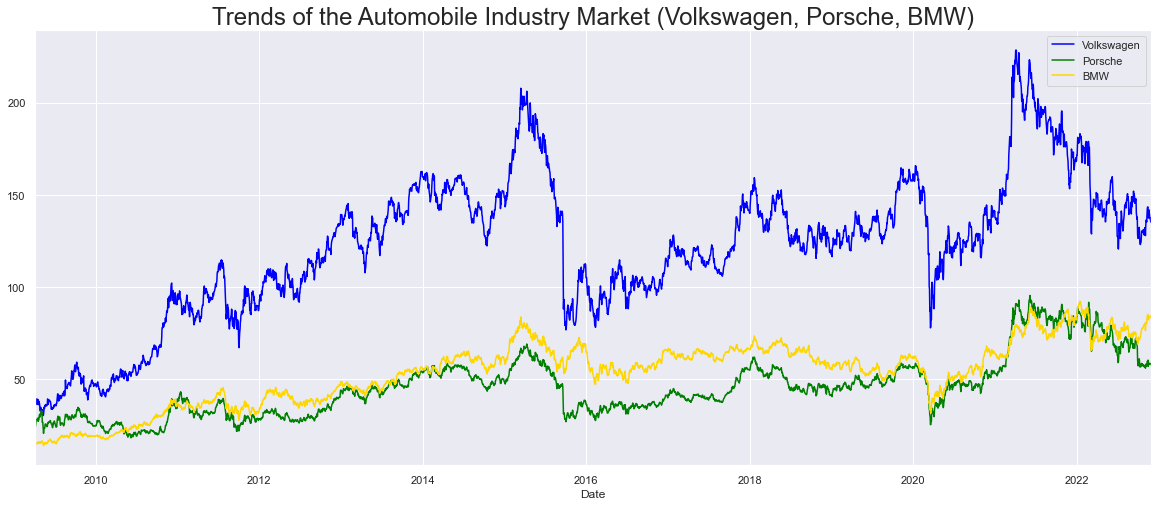

In [14]:
# Plot the prices of all the companies till date

df['vol'][start_date:].plot(figsize= (20,8), color = "blue")
df['por'][start_date:].plot(color = "green")
df['bmw'][start_date:].plot(color = "gold")
plt.legend(['Volkswagen','Porsche','BMW'])
plt.title("Trends of the Automobile Industry Market (Volkswagen, Porsche, BMW)", size = 24)
plt.show()

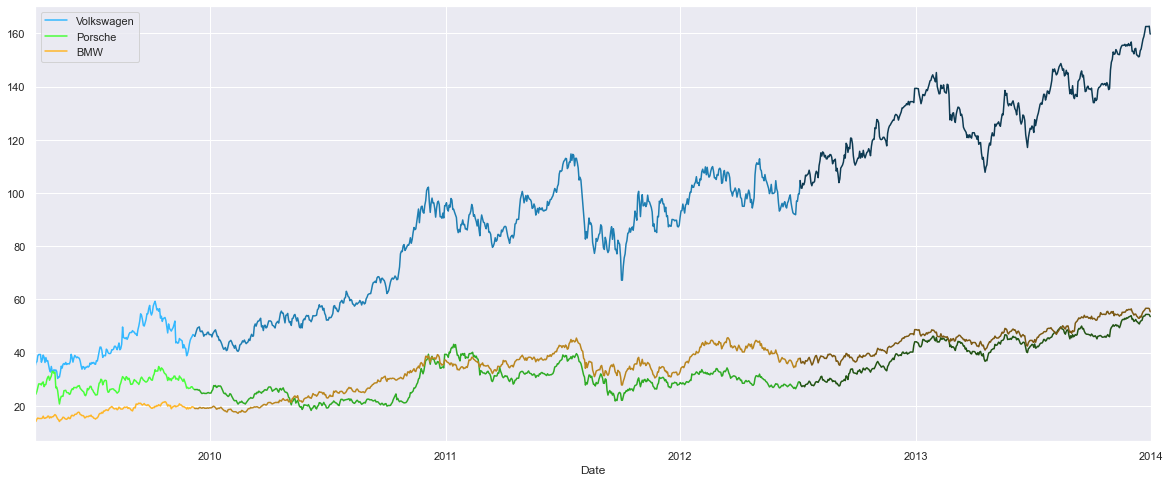

In [15]:
# Plots the prices of all companies, and segments the relevant periods with colours

df['vol'][start_date:ann_1].plot(figsize= (20,8), color = "#33B8FF")
df['por'][start_date:ann_1].plot(color = "#49FF3A")
df['bmw'][start_date:ann_1].plot(color = "#FEB628")

df['vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['por'][ann_1:ann_2].plot(color = "#2FAB25")
df['bmw'][ann_1:ann_2].plot(color = "#BA861F")

df['vol'][ann_2:end_date].plot(color = "#0E3A52")
df['por'][ann_2:end_date].plot(color = "#225414")
df['bmw'][ann_2:end_date].plot(color = "#7C5913")

plt.legend(['Volkswagen','Porsche','BMW'])

plt.show()

### Correlation Analysis
This is to compare each time series, to the other.

In [16]:
# Correlation among manufacturers from 2009 - 2014

print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8359547002575028
Volkswagen and BMW correlation: 	0.9799378220306187
Porsche and BMW correlation: 		0.8052157756374784


Note: There is a higher correlation between Volswagen and BMW(the self defined market benchmark), which suggests the prices of VW and BMW moves similarly.

In [17]:
# Correlation among manufacturers from April 2009 (start date) - Dec 2009(first aquisition)

print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.6633584884302339
Volkswagen and BMW correlation: 	0.8427607417493593
Porsche and BMW correlation: 		0.609503929361692


Note: Porsche and BMW is the least correlated, which suggests that the stock prices between these brands were not similar before the start of the acquisition.

As the prices of the Porsche are being influenced by VW acquisition, and VW consequently becoming a trendsetter for other companies e.g BMW.

To confirm this claim, we analyse the correlation of the companies between the first acquisition and before the second below.

In [18]:
# Correlation among manufacturers from Dec 2009(first aquisition) - July 2012(second aquisition)

print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7428268218704516
Volkswagen and BMW correlation: 	0.9795942997500349
Porsche and BMW correlation: 		0.7042723547562012


Note: The drastic increase between VW and BMW, which confirms the claim that VW becomes a trendsetter after its partial take out of Porsche.

In [19]:
# Correlation among manufacturers from July 2012(second aquisition) - end_date(self defined time series end date)
# Correlation after the complete buy out of Porsche by Volkswagen

print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.9405236948186029
Volkswagen and BMW correlation: 	0.9284446956027902
Porsche and BMW correlation: 		0.9494111565504205


Note: The high correlation between VW and Porsche, shows that both are truly recognised as a single entity and chnages in orice of one affects the other.

In [20]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][end_date:end_date2].corr(df['por'][end_date:end_date2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][end_date:end_date2].corr(df['bmw'][end_date:end_date2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:end_date2].corr(df['bmw'][end_date:end_date2])))

Correlation among manufacturers from 2014-01-01 to 2022-11-29 00:00:00

Volkswagen and Porsche correlation: 	0.9695092572276935
Volkswagen and BMW correlation: 	0.5391814513514063
Porsche and BMW correlation: 		0.5116478486708869


Note: The correlation between Volkswagen and Porsche is still high in comparison to the market benchmark (BMW).

This signifies the effect of the diesel gate scandal on VW and consequently Porsches prices.

## Corona Virus Analysis

See how prices faired during the corona virus pandemic

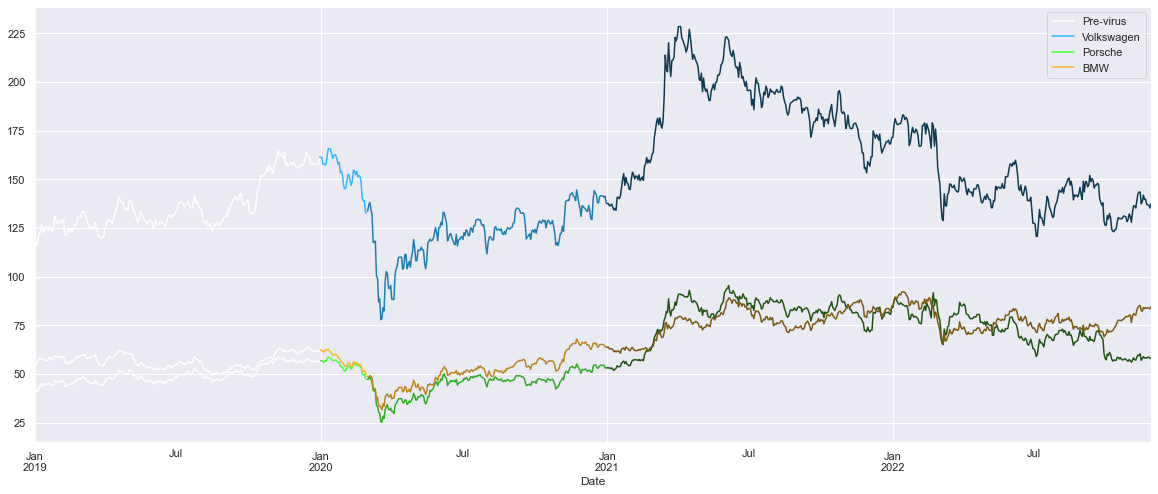

In [21]:
# Plots the prices of all companies, and segments the relevant periods with colours

# First plot of the pre-virus chart
df['vol']['2019-01-01':end_date2].plot(figsize= (20,8), color = "white")

df['vol'][end_date2:lockdown].plot(figsize= (20,8), color = "#33B8FF")
df['por'][end_date2:lockdown].plot(color = "#49FF3A")
df['bmw'][end_date2:lockdown].plot(color = "#FEB628")

df['vol'][lockdown:lockdown_ease].plot(color = "#1E7EB2")
df['por'][lockdown:lockdown_ease].plot(color = "#2FAB25")
df['bmw'][lockdown:lockdown_ease].plot(color = "#BA861F")

df['vol'][lockdown_ease:].plot(color = "#0E3A52")
df['por'][lockdown_ease:].plot(color = "#225414")
df['bmw'][lockdown_ease:].plot(color = "#7C5913")

# Other 2 plots of the pre-virus chart
df['por']['2019-01-01':end_date2].plot(color = "white")
df['bmw']['2019-01-01':end_date2].plot(color = "white")

plt.legend(["Pre-virus",'Volkswagen','Porsche','BMW'])

plt.show()

We can see that the stock prices followed a downward trend even before the start of the lockdown, but at the start of the lockdown the stock plummets even deeper by over 55%.

After the global easing of the lockdown as at january 2021, the stocks followed an upward trajectory and recovered strongly from pre-virus prices, between march and april 2022.

###  Correlation Analysis

In [22]:
# Correlation among manufacturers from between the start of the corona virus and before the Global lockdwon

print('Correlation among manufacturers from ' + str(end_date2) + ' to ' + str(lockdown)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][end_date2:lockdown].corr(df['por'][end_date2:lockdown])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][end_date2:lockdown].corr(df['bmw'][end_date2:lockdown])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date2:lockdown].corr(df['bmw'][end_date2:lockdown])))

Correlation among manufacturers from 2019-12-31 to 2020-03-01

Volkswagen and Porsche correlation: 	0.9907879299882191
Volkswagen and BMW correlation: 	0.929372492856484
Porsche and BMW correlation: 		0.9319453301371275


In [23]:
# Correlation among manufacturers from during the lockdown

print('Correlation among manufacturers from ' + str(lockdown) + ' to ' + str(lockdown_ease)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][lockdown:lockdown_ease].corr(df['por'][lockdown:lockdown_ease])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][lockdown:lockdown_ease].corr(df['bmw'][lockdown:lockdown_ease])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][lockdown:lockdown_ease].corr(df['bmw'][lockdown:lockdown_ease])))

Correlation among manufacturers from 2020-03-01 to 2021-01-01

Volkswagen and Porsche correlation: 	0.9621584505803231
Volkswagen and BMW correlation: 	0.9111885976695154
Porsche and BMW correlation: 		0.9304789346908355


In [24]:
# Correlation among manufacturers after the global easing of lockdown

print('Correlation among manufacturers from ' + str(lockdown_ease) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][lockdown_ease:].corr(df['por'][lockdown_ease:])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][lockdown_ease:].corr(df['bmw'][lockdown_ease:])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][lockdown_ease:].corr(df['bmw'][lockdown_ease:])))

Correlation among manufacturers from 2021-01-01 to 2022-11-29 00:00:00

Volkswagen and Porsche correlation: 	0.8088543601552199
Volkswagen and BMW correlation: 	0.3796387229191686
Porsche and BMW correlation: 		0.5586359007716658


Note: The correlation between VW and Porsche is high, because both prices affect the other, since VW total buyout of Porsche.

But their correlation with the market benchmark (BMW) is low, as a result of the changes caused by the pandemic.

# Forecasting

## Best Fitting Models

### For Volkswagen

In [25]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [26]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -313.553
Date:                Tue, 29 Nov 2022   AIC                            637.106
Time:                        17:37:10   BIC                            653.015
Sample:                    04-06-2009   HQIC                           643.557
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6858      0.424      1.618      0.106      -0.145       1.517
por            0.3925      0.094      4.169      0.000       0.208       0.577
bmw            0.7059      0.335      2.107      0.035       0.049       1.363
ar.L1          0.9633      0.020     48.670      0.000       0.925       1.002
sigma2         1.9550      0.133     14.718      0.000       1.695       2.215
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):               166.03
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1044.484
Date:                Tue, 29 Nov 2022   AIC                           2094.968
Time:                        17:37:10   BIC                           2108.494
Sample:                    12-09-2009   HQIC                          2100.207
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.7760      0.060     12.842      0.000       0.658       0.894
bmw            1.5801      0.074     21.269      0.000       1.435       1.726
sigma2         1.3170      0.054     24.532      0.000       1.212       1.422
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               112.42
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -587.155
Date:                Tue, 29 Nov 2022   AIC                           1180.309
Time:                        17:37:11   BIC                           1192.200
Sample:                    07-05-2012   HQIC                          1185.023
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.6868      0.056     30.369      0.000       1.578       1.796
bmw            0.8749      0.093      9.381      0.000       0.692       1.058
sigma2         1.1983      0.059     20.461      0.000       1.084       1.313
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               103.80
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### For Porsche

In [29]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol','bmw']][ann_2:end_date],
                             m = 5, max_p = 5, max_q = 5)

In [30]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -219.737
Date:                Tue, 29 Nov 2022   AIC                            451.474
Time:                        17:37:38   BIC                            470.565
Sample:                    04-06-2009   HQIC                           459.216
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5562      0.363      1.533      0.125      -0.155       1.267
vol            0.1172      0.054      2.157      0.031       0.011       0.224
bmw            0.9170      0.165      5.558      0.000       0.594       1.240
ar.L1          1.0748      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.6837      0.048     14.098      0.000       0.589       0.779
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               559.39
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -558.076
Date:                Tue, 29 Nov 2022   AIC                           1126.153
Time:                        17:37:38   BIC                           1148.696
Sample:                    12-09-2009   HQIC                          1134.884
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1819      0.016     11.134      0.000       0.150       0.214
bmw            0.3449      0.048      7.200      0.000       0.251       0.439
ar.L1          0.6585      0.230      2.860      0.004       0.207       1.110
ma.L1         -0.5898      0.246     -2.394      0.017      -1.073      -0.107
sigma2         0.3090      0.010     32.415      0.000       0.290       0.328
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1076.51
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -196.988
Date:                             Tue, 29 Nov 2022   AIC                            401.976
Time:                                     17:37:38   BIC                            417.830
Sample:                                 07-05-2012   HQIC                           408.261
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2261      0.013     16.876      0.000       0.200       0.252
bmw            0.2604      0.043      6.036      0.000       0.176       0.345
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1612      0.006     27.851      0.000       0.150       0.173
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):               613.61
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the Future

### For Porsche

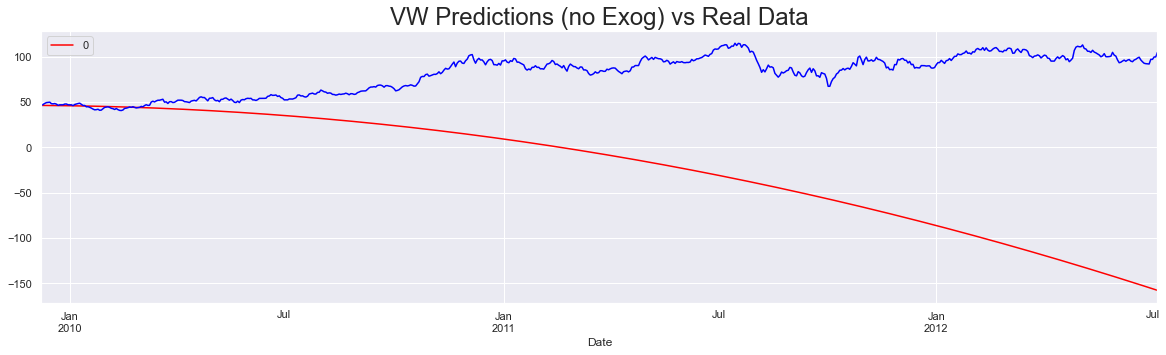

In [33]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2])), index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data", size = 24)
plt.show()

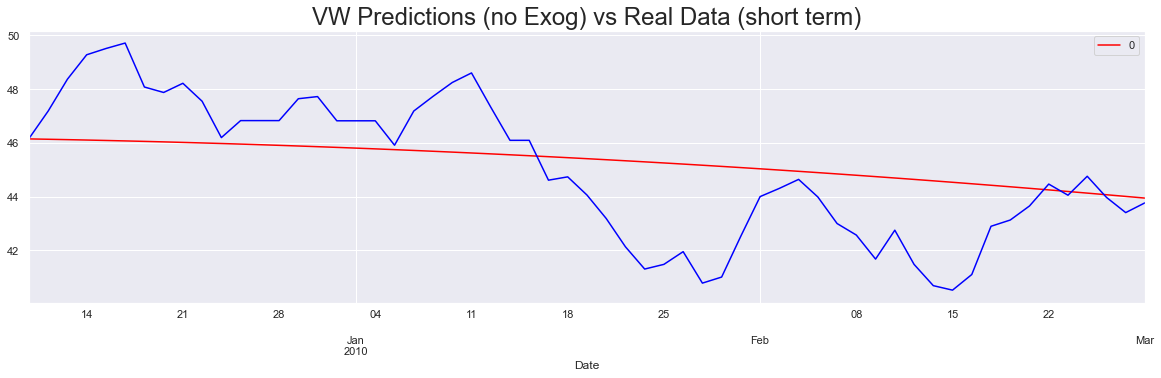

In [34]:
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize = (20,5), color = "red")
df.vol[ann_1:'2010-03-01'].plot(color = "blue")
plt.title("VW Predictions (no Exog) vs Real Data (short term)", size = 24)
plt.show()

### For Volkswagen

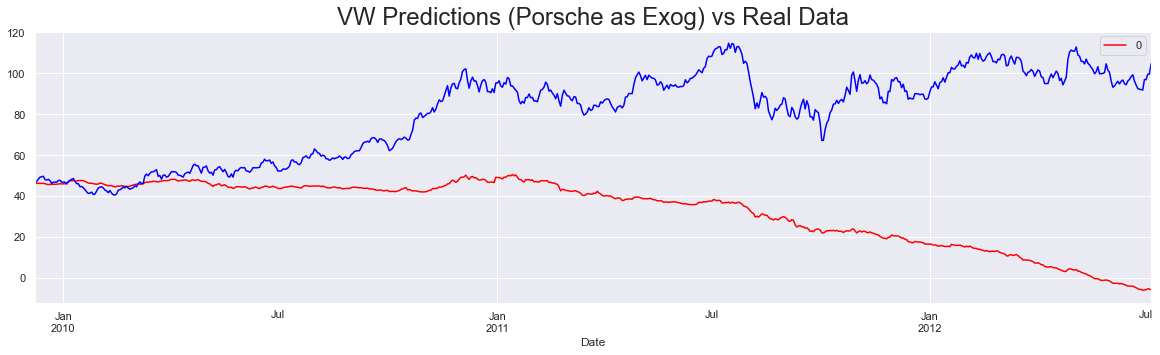

In [35]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]),exogenous = df[['por']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Porsche as Exog) vs Real Data", size = 24)
plt.show()

### Predicting prices after first acquisition

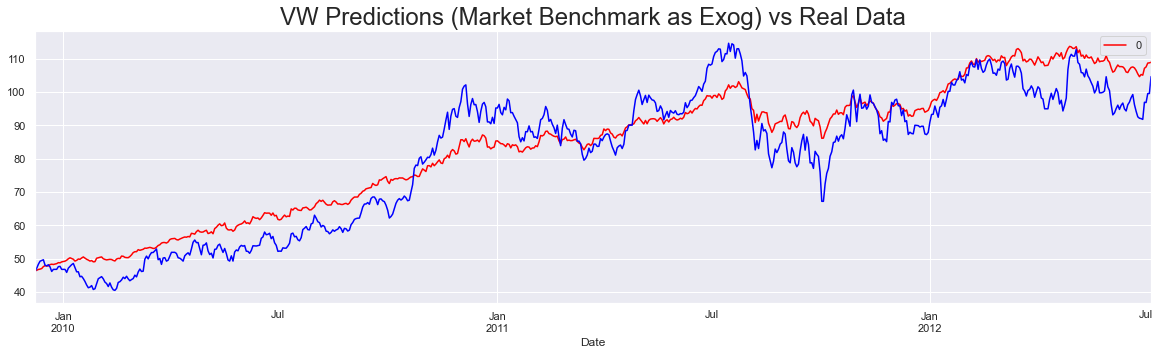

In [36]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], exogenous = df[['bmw']][start_date:ann_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[ann_1:ann_2]), exogenous = df[['bmw']][ann_1:ann_2]),
                               index = df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize = (20,5), color = "red")

df.vol[ann_1:ann_2].plot(color = "blue")
plt.title("VW Predictions (Market Benchmark as Exog) vs Real Data", size = 24)
plt.show()

### Post Corona virus forecasting

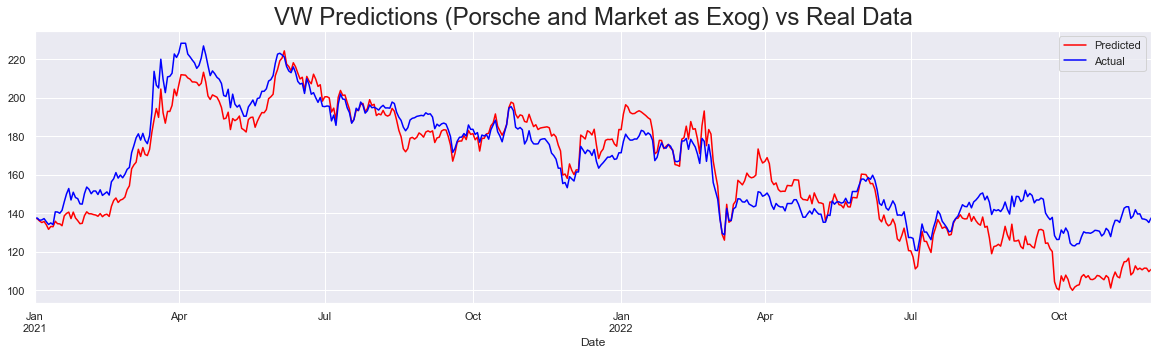

In [37]:
model_auto_pred_pr = auto_arima(df.vol[lockdown:lockdown_ease], exogenous = df[['por', 'bmw']][lockdown:lockdown_ease],
                                max_order = None, m = 5, max_p = 5, max_q = 5, max_d = 2, max_P = 15, max_Q = 15,max_D = 10,
                                maxiter = 50, alpha = 0.05, n_jobs = -1, information_criterion = 'aic', trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[lockdown_ease:]), exogenous = df[['por','bmw']][lockdown_ease:]),
                               index = df[lockdown_ease:].index)
df_auto_pred_pr[lockdown_ease:].plot(figsize = (20,5), color = "red")

df.vol[lockdown_ease:].plot(color = "blue")
plt.title("VW Predictions (Porsche and Market as Exog) vs Real Data", size = 24)
plt.legend(["Predicted",'Actual'])
plt.show()

## Volatility

### Volatility of VW for Each Period (Before, During and After the Corona Virus lockdown)

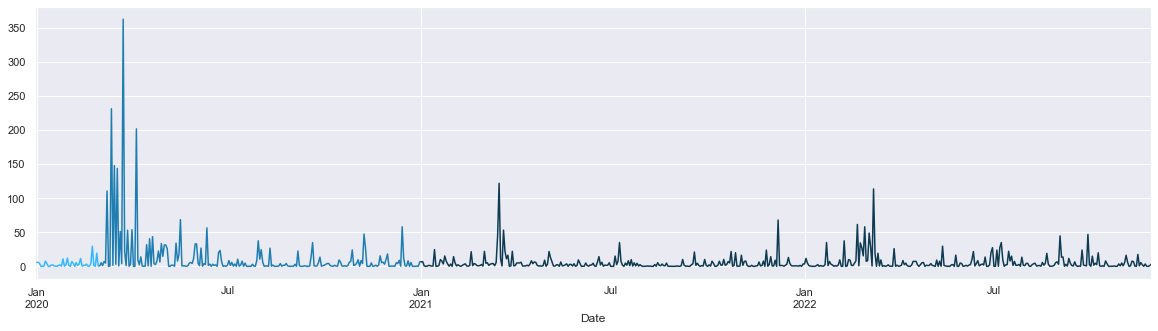

In [38]:
# Before lockdown
df['sq_vol'][end_date2:lockdown].plot(figsize = (20,5), color = "#33B8FF")

# During lockdown
df['sq_vol'][lockdown:lockdown_ease].plot(color = "#1E7EB2")

# After lockdown
df['sq_vol'][lockdown_ease:].plot(color = "#0E3A52")
plt.show()


### Volatility Trends for Each Period

In [39]:
model_garch_pre = arch_model(df.ret_vol[end_date2:lockdown], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[lockdown:lockdown_ease], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[lockdown_ease:], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     29,   Neg. LLF: 91.02495993014506
Iteration:     10,   Func. Count:     54,   Neg. LLF: 91.01241588913216
Iteration:     15,   Func. Count:     78,   Neg. LLF: 91.00440310334106
Optimization terminated successfully    (Exit mode 0)
            Current function value: 91.00440310288944
            Iterations: 15
            Function evaluations: 78
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     34,   Neg. LLF: 567.8961792374962
Iteration:     10,   Func. Count:     64,   Neg. LLF: 102334423.12540622
Iteration:     15,   Func. Count:     96,   Neg. LLF: 550.8618199890145
Iteration:     20,   Func. Count:    122,   Neg. LLF: 549.4892489698245
Optimization terminated successfully    (Exit mode 0)
            Current function value: 549.4892489677268
            Iterations: 21
            Function evaluations: 122
            Gradient evaluations: 20
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1107.077301014694
Opti

In [40]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -91.0044
Distribution:                  Normal   AIC:                           190.009
Method:            Maximum Likelihood   BIC:                           197.146
                                        No. Observations:                   44
Date:                Tue, Nov 29 2022   Df Residuals:                       43
Time:                        17:37:58   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.2606      0.289     -0.901      0.368 [ -0.828,  0.306]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          3.6646      1.563      2.344  1.908e-02      [  0.600,  6.729]
alpha[1]       0.0000  9.900e-03      0.000      1.000 [-1.940e-02,1.940e-02]
beta[1]    1.2102e-10      0.428  2.828e-10      1.000      [ -0.839,  0.839]
=============================================================================

Covariance estimator: robust
"""

In [41]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -549.489
Distribution:                  Normal   AIC:                           1106.98
Method:            Maximum Likelihood   BIC:                           1120.55
                                        No. Observations:                  220
Date:                Tue, Nov 29 2022   Df Residuals:                      219
Time:                        17:37:58   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1236      0.172      0.718      0.473 [ -0.214,  0.461]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.1310      0.175      0.747      0.455 [ -0.213,  0.475]
alpha[1]   5.9235e-17  9.861e-02  6.007e-16      1.000 [ -0.193,  0.193]
beta[1]        0.9712      0.126      7.693  1.441e-14 [  0.724,  1.219]
========================================================================

Covariance estimator: robust
"""

In [42]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1106.99
Distribution:                  Normal   AIC:                           2221.98
Method:            Maximum Likelihood   BIC:                           2238.82
                                        No. Observations:                  498
Date:                Tue, Nov 29 2022   Df Residuals:                      497
Time:                        17:37:58   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1061  9.845e-02      1.078      0.281 [-8.682e-02,  0.299]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.8640      0.365      2.367  1.794e-02   [  0.149,  1.580]
alpha[1]       0.1349  5.626e-02      2.397  1.653e-02 [2.458e-02,  0.245]
beta[1]        0.7035  9.971e-02      7.055  1.723e-12   [  0.508,  0.899]
==========================================================================

Covariance estimator: robust
"""